### Challenge
At FakeFashionCorp, we're always looking to **improve our product recommendations for our customers**. As a member of our data science team, your task is to make the best recommendations possible based on the provided data:

- **Customer Search Data**: A list of google search queries made by a **specific** customer. You can find the data in the `./search_history.json` file.
- **Product Catalog**: A dataset containing 100,000 **fashion items** from our current inventory, including details such as product name, category, description, and other relevant attributes. You can find the data in the `./fashion_catalog.json` file.

Your challenge is to analyze the customer's search history and use this information to select the most relevant items from our product catalog that we should recommend to this customer.

Here are the specific requirements:

- Select the top items that best match the customer's apparent interests and preferences.
- Provide a brief explanation of your approach, including any assumptions you made and the reasoning behind your methodology.
- Include any visualizations or metrics that support your recommendations.
- Make sure to include the cell output in the final commit, we will **not** execute the script ourselves.

### Dummy approach
The following is what we consider a **dummy** approach. We expect you to find a more clever solution that this:
1. embed the customer's searches
2. rank the searches according to some semantic similarity to a fashion related anchor
3. for each fashion related search, find the product in the catalog that is most similar

We encourage you to be creative in your approach. There's no single correct solution, and we're interested in seeing how you tackle this real-world problem.

Hint: **how can we truly understand the customer's preferences?**

In [97]:
# Purpose: Setting up the notebook & importing Libraries

import json
import pandas as pd
import numpy as np
import time

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="husl")

# ML & Embeddings
# using sentence-transformers since it is open-source and widely adopted for generating text embeddings
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize 

# Fast similarity search for 100k products
# Using FAISS for efficient and optimised similarity search compared to a normal KNN implementation
import faiss

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [98]:
# Purpose: Loading the available datasets

# Loading search history dataset available in JSON format
with open('search_history.json', 'r') as f:
    search_history = json.load(f)

# Loading fashion catalog dataset available in JSON format
with open('fashion_catalog.json', 'r') as f:
    catalog = json.load(f)

# Converting the loaded JSON datasets to dataFrames for analysis
search_df = pd.DataFrame(search_history)
catalog_df = pd.DataFrame(catalog)

print(f"Google Search History: {len(search_df):,} search queries.")
print(f"Fashion Catalog: {len(catalog_df):,} products.")
print(f"\nSearch column headers: {list(search_df.columns)}")
print(f"Catalog column headers: {list(catalog_df.columns)}")

# Preview the data
print("\n--- Sample Search Dataset (First 2 Rows) ---")
display(search_df.head(2))
print("\n--- Sample Catalog Dataset (First 2 Rows) ---")
display(catalog_df.head(2))

Google Search History: 55,383 search queries.
Fashion Catalog: 100,000 products.

Search column headers: ['header', 'title', 'titleUrl', 'time', 'products', 'activityControls', 'locationInfos', 'subtitles', 'details']
Catalog column headers: ['MAIN_IMAGE', 'SECOND_IMAGE', 'THIRD_IMAGE', 'FOURTH_IMAGE', 'LYST_PRODUCT_URL', 'GENDER', 'CATEGORY', 'SHORT_DESCRIPTION', 'LONG_DESCRIPTION']

--- Sample Search Dataset (First 2 Rows) ---


,header,title,titleUrl,time,products,activityControls,locationInfos,subtitles,details
0,Search,Visited https://www.businessinsider.com/shivon...,https://www.google.com/url?q=https://www.busin...,2024-06-23T22:21:50.431Z,[Search],[Web & App Activity],NaN,NaN,NaN
1,Search,Visited Elon Musk and Shivon Zilis privately w...,https://www.google.com/url?q=https://www.nbcph...,2024-06-23T22:20:53.934Z,[Search],[Web & App Activity],NaN,NaN,NaN



--- Sample Catalog Dataset (First 2 Rows) ---


,MAIN_IMAGE,SECOND_IMAGE,THIRD_IMAGE,FOURTH_IMAGE,LYST_PRODUCT_URL,GENDER,CATEGORY,SHORT_DESCRIPTION,LONG_DESCRIPTION
0,https://cdna.lystit.com/photos/wolfandbadger/5...,None,None,None,https://www.lyst.com/shoes/laines-london-class...,F,flats,Classic Laines Slippers With Pearl Beaded Lobs...,Our faux fur cross strap classic slippers offe...
1,https://cdna.lystit.com/photos/farfetch/d774e2...,https://cdna.lystit.com/photos/farfetch/8b088f...,https://cdna.lystit.com/photos/farfetch/6a4008...,None,https://www.lyst.com/clothing/oscar-de-la-rent...,F,skirts,Dahlia Floral-print Midi Skirt,Material:Polyester. This item may not be on sa...


In [99]:
# Purpose: Parsing & Structuring Search Events for Analysis

def parse_search_event(row):
    """Extracting structured info from each search event in the format of:
    - event_text: The main text of the event (search query or visited page)
    - event_type: 'search' or 'visit' to help categorize events
    - timestamp: Parsed datetime of the event to help with recency analysis
    - url: The URL associated with the event
    - raw_title: The original title text from the event"""

    title = row.get('title', '')
    
    # Determine event type
    if title.startswith('Visited '):
        event_type = 'visit'
        event_text = title.replace('Visited ', '')
    elif title.startswith('Searched for '):
        event_type = 'search'
        event_text = title.replace('Searched for ', '')
    else:
        event_type = 'other'
        event_text = title
    
    # Parse timestamp
    time_str = row.get('time', '')
    try:
        timestamp = pd.to_datetime(time_str)
    except:
        timestamp = pd.NaT
    
    # Extract URL
    url = row.get('titleUrl', '')
    
    return pd.Series({
        'event_text': event_text,
        'event_type': event_type,
        'timestamp': timestamp,
        'url': url,
        'raw_title': title
    })

# Apply parsing
parsed_df = search_df.apply(parse_search_event, axis=1)
parsed_df = parsed_df.dropna(subset=['timestamp'])
parsed_df = parsed_df.sort_values('timestamp', ascending=False).reset_index(drop=True)

print(f"Parsed {len(parsed_df):,} events")
print(f"\nEvent type distribution:")
print(parsed_df['event_type'].value_counts())
print(f"\nDate range of the dataset: {parsed_df['timestamp'].min().date()} to {parsed_df['timestamp'].max().date()}")

# Preview parsed data
print("\n--- Sample Parsed Events ---")
display(parsed_df.head(5))

Parsed 55,383 events

Event type distribution:
event_type
search    30542
visit     22496
other      2345
Name: count, dtype: int64

Date range of the dataset: 2017-06-08 to 2024-06-23

--- Sample Parsed Events ---


,event_text,event_type,timestamp,url,raw_title
0,https://www.businessinsider.com/shivon-zilis-r...,visit,2024-06-23 22:21:50.431000+00:00,https://www.google.com/url?q=https://www.busin...,Visited https://www.businessinsider.com/shivon...
1,Elon Musk and Shivon Zilis privately welcome t...,visit,2024-06-23 22:20:53.934000+00:00,https://www.google.com/url?q=https://www.nbcph...,Visited Elon Musk and Shivon Zilis privately w...
2,elon musk shivon zilis,search,2024-06-23 22:20:47.560000+00:00,https://www.google.com/search?q=elon+musk+shiv...,Searched for elon musk shivon zilis
3,1 notification,other,2024-06-23 17:08:38.542000+00:00,NaN,1 notification
4,bank station fire alert,search,2024-06-23 16:52:09.311000+00:00,https://www.google.com/search?q=bank+station+f...,Searched for bank station fire alert


In [100]:
# Purpose: URL Analysis by extracting Brand & Retailer Preferences

from urllib.parse import urlparse

def extract_domain(url):
    """Extract clean domain from URL."""
    try:
        if not url or pd.isna(url):
            return ''
        parsed = urlparse(url)
        domain = parsed.netloc.replace('www.', '').lower()
        return domain
    except:
        return ''

# Apply to parsed data
parsed_df['domain'] = parsed_df['url'].apply(extract_domain)

# Assumption: Defining fashion-related domain categories
fashion_domains = {
    # Luxury brands
    'hermes.com': ('Hermès', 'luxury'),
    'gucci.com': ('Gucci', 'luxury'),
    'prada.com': ('Prada', 'luxury'),
    'louisvuitton.com': ('Louis Vuitton', 'luxury'),
    'chanel.com': ('Chanel', 'luxury'),
    'dior.com': ('Dior', 'luxury'),
    'balenciaga.com': ('Balenciaga', 'luxury'),
    'bottegaveneta.com': ('Bottega Veneta', 'luxury'),
    'celine.com': ('Celine', 'luxury'),
    'ysl.com': ('YSL', 'luxury'),
    'burberry.com': ('Burberry', 'luxury'),
    
    # Premium/Contemporary
    'toryburch.com': ('Tory Burch', 'premium'),
    'coach.com': ('Coach', 'premium'),
    'michaelkors.com': ('Michael Kors', 'premium'),
    'katespade.com': ('Kate Spade', 'premium'),
    'tommyhilfiger.com': ('Tommy Hilfiger', 'premium'),
    'ralphlauren.com': ('Ralph Lauren', 'premium'),
    'calvinklein.com': ('Calvin Klein', 'premium'),
    
    # Fast fashion
    'zara.com': ('Zara', 'fast_fashion'),
    'hm.com': ('H&M', 'fast_fashion'),
    'uniqlo.com': ('Uniqlo', 'fast_fashion'),
    'mango.com': ('Mango', 'fast_fashion'),
    'asos.com': ('ASOS', 'fast_fashion'),
    'shein.com': ('Shein', 'fast_fashion'),
    
    # Department stores & multi-brand
    'nordstrom.com': ('Nordstrom', 'department'),
    'saksfifthavenue.com': ('Saks', 'department'),
    'neimanmarcus.com': ('Neiman Marcus', 'department'),
    'bloomingdales.com': ('Bloomingdales', 'department'),
    'macys.com': ('Macys', 'department'),
    'shopbop.com': ('Shopbop', 'department'),
    'net-a-porter.com': ('Net-a-Porter', 'luxury_retailer'),
    'farfetch.com': ('Farfetch', 'luxury_retailer'),
    'ssense.com': ('SSENSE', 'luxury_retailer'),
    'mytheresa.com': ('Mytheresa', 'luxury_retailer'),
    'lyst.com': ('Lyst', 'aggregator'),
    
    # Footwear specialists
    'nike.com': ('Nike', 'athletic'),
    'adidas.com': ('Adidas', 'athletic'),
    'newbalance.com': ('New Balance', 'athletic'),
    'footlocker.com': ('Foot Locker', 'athletic'),
    'zappos.com': ('Zappos', 'footwear'),
    'dsw.com': ('DSW', 'footwear'),
}

def classify_domain(domain):
    """Classify a domain into brand/category."""
    if not domain:
        return None, None, False
    
    # Direct match
    if domain in fashion_domains:
        brand, category = fashion_domains[domain]
        return brand, category, True
    
    # Partial match (e.g., 'us.hermes.com' or 'shop.gucci.com')
    for known_domain, (brand, category) in fashion_domains.items():
        if known_domain in domain or domain.endswith(known_domain):
            return brand, category, True
    
    return None, None, False

# Apply classification
domain_info = parsed_df['domain'].apply(lambda d: pd.Series(classify_domain(d)))
domain_info.columns = ['brand', 'brand_category', 'is_fashion_domain']
parsed_df = pd.concat([parsed_df, domain_info], axis=1)

# Fashion domain visits
fashion_domain_visits = parsed_df[parsed_df['is_fashion_domain']]
print(f"\nFashion domain visits: {len(fashion_domain_visits):,} ({len(fashion_domain_visits)/len(parsed_df)*100:.1f}%)")

# Top brands by visit count
if len(fashion_domain_visits) > 0:
    print("\nTop Brands by Visit Count:")
    brand_counts = fashion_domain_visits['brand'].value_counts().head(15)
    display(brand_counts)
    
    # Brand category distribution
    print("\nBrand Category Distribution:")
    category_counts = fashion_domain_visits['brand_category'].value_counts()
    display(category_counts)
    
    # Price tier affinity based on self assumption
    tier_weights = {
        'luxury': 4,
        'luxury_retailer': 3.5,
        'premium': 2.5,
        'department': 2,
        'fast_fashion': 1,
        'athletic': 1.5,
        'footwear': 1.5,
        'aggregator': 1
    }
    
    category_weighted = fashion_domain_visits['brand_category'].map(tier_weights)
    avg_tier = category_weighted.mean()
    print(f"\n Average Price Tier Score: {avg_tier:.2f}")
    print("   (1 = budget, 4 = luxury)")
    
    if avg_tier >= 3:
        print("Customer shows LUXURY preferences")
    elif avg_tier >= 2:
        print("Customer shows PREMIUM preferences")
    else:
        print("Customer shows VALUE/BUDGET preferences")
else:
    print("\n No recognized fashion domains found in URLs")

# All unique domains (for discovery)
print("\n All Unique Domains Visited (top 30):")
all_domains = parsed_df[parsed_df['domain'] != '']['domain'].value_counts().head(30)
display(all_domains)


Fashion domain visits: 0 (0.0%)

 No recognized fashion domains found in URLs

 All Unique Domains Visited (top 30):


domain
google.com                        52714
local.google.com                   1862
youtube.com                         126
m.youtube.com                       106
google.co.uk                         78
maps.google.co.uk                    22
maps.google.com                      15
books.google.com                     14
support.google.com                   10
colab.research.google.com             9
developers.google.com                 7
play.google.com                       7
scholar.google.com                    5
chrome.google.com                     5
drive.google.com                      4
research.google.com                   3
docs.google.com                       3
calcutta-regalia.business.site        3
calendar.google.com                   3
hangouts.google.com                   2
groups.google.com                     2
careers.google.com                    2
tv.youtube.com                        2
meet.google.com                       2
firebase.google.com              

In [101]:
# I thought of using URLs in the user query dataset to extract brand and retailer preferences because URLs 
# often contain the domain names of the brands or retailers being visited. By analyzing these domains, we can infer 
# which brands the user is interested in based on their browsing history. This method provides a straightforward way 
# to categorize user preferences without needing complex natural language processing on search queries or page titles. 
# Additionally, domain analysis can help identify patterns in shopping behavior, such as preferences for 
# luxury versus fast fashion brands, which is valuable for tailoring recommendations and marketing strategies.
# But based on the above URL domain analysis the user query dataset only has google search hostiry and not the actual
# fashion retailer website visit history. Hence we cannot extract any brand or retailer preferences from the URLs
# and add it as a weighted score to the user profile for further analysis.

In [102]:
# Purpose: Computing Recency (Exponential Decay) & Repetition Weights

def compute_weights(df, half_life_days=30):
    """
    Computing importance weights based on:
    - Recency: exponential decay (newer = higher weight)
    - Repetition: repeated topics get boosted
    - Event type: visits > searches
    """
    df = df.copy()
    
    # Recency weight (exponential decay) because newer events are more relevant
    now = df['timestamp'].max()
    days_ago = (now - df['timestamp']).dt.total_seconds() / (24 * 3600)
    df['recency_weight'] = np.exp(-days_ago / half_life_days)
    
    # Repetition weight (count similar texts) because repeated events indicate stronger interest
    text_counts = df['event_text'].str.lower().value_counts()
    df['repetition_count'] = df['event_text'].str.lower().map(text_counts)
    df['repetition_weight'] = np.log1p(df['repetition_count'])  # log scale
    
    # Event type weight (visits are stronger signals) because visiting a page indicates higher intent than just searching
    type_weights = {'visit': 1.5, 'search': 1.0, 'other': 0.5}
    df['type_weight'] = df['event_type'].map(type_weights)
    
    # Combined weight of all factors
    df['combined_weight'] = df['recency_weight'] * df['repetition_weight'] * df['type_weight']
    
    # Normalize to [0, 1] because combined weights can vary widely
    df['combined_weight'] = df['combined_weight'] / df['combined_weight'].max()
    
    return df

parsed_df = compute_weights(parsed_df)

print("✅ Weights computed")
print(f"\nWeight statistics:")
print(parsed_df[['recency_weight', 'repetition_weight', 'type_weight', 'combined_weight']].describe())

# Show top weighted events
print("\nTop 10 highest-weighted events:")
display(parsed_df.nlargest(10, 'combined_weight')[['event_text', 'event_type', 'combined_weight']])

✅ Weights computed

Weight statistics:
       recency_weight  repetition_weight   type_weight  combined_weight
count    5.538300e+04       55383.000000  55383.000000     5.538300e+04
mean     6.912439e-03           0.937133      1.181924     1.278221e-03
std      5.401123e-02           0.655739      0.281137     1.324595e-02
min      5.795344e-38           0.693147      0.500000     6.938710e-39
25%      1.429206e-24           0.693147      1.000000     2.140878e-25
50%      1.327289e-15           0.693147      1.000000     2.337689e-16
75%      8.491374e-10           0.693147      1.500000     1.347211e-10
max      1.000000e+00           5.141664      1.500000     1.000000e+00

Top 10 highest-weighted events:


,event_text,event_type,combined_weight
29,Google Search,visit,1.000000
74,Google Search,visit,0.958528
94,Google Search,visit,0.839742
282,Google Search,visit,0.583606
338,Google Search,visit,0.556288
439,Google Search,visit,0.440049
3,1 notification,other,0.433505
12,1 notification,other,0.412363
111,israel,search,0.411374
113,israel,search,0.411336


In [103]:
# Purpose: Data Cleanup & Noise Filtering

def clean_events(df):
    """Removing noise and low-value events before final analysis."""
    df = df.copy()
    original_count = len(df)
    
    # Removing generic/noise patterns which I found while skimming through the dataset
    # and which do not add value to user intent analysis
    # There could be more sophisticated NLP-based noise detection which would need more time to
    # explore the dataset further.
    noise_patterns = [
        r'^google search$',
        r'^google$',
        r'^\d+ notification',
        r'^notification$',
        r'^https?://',  # Raw URLs without titles (low info)
        r'^www\.',
        r'^sign in',
        r'^log in',
        r'^account',
        r'gmail',
        r'google maps',
        r'google translate',
        r'^map of',
        r'^directions to',
        r'^weather',
    ]
    
    noise_regex = '|'.join(noise_patterns)
    noise_mask = df['event_text'].str.lower().str.match(noise_regex, na=False)
    df = df[~noise_mask]
    
    # Assumption: Removing very short texts (< 3 chars) since they are likely noise
    df = df[df['event_text'].str.len() >= 3]
    
    # Assumption: Removing duplicates within short time windows (< 1 min = same search session)
    df = df.sort_values('timestamp')
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds().abs()
    df['is_duplicate'] = (df['event_text'] == df['event_text'].shift()) & (df['time_diff'] < 60)
    df = df[~df['is_duplicate']]
    df = df.drop(columns=['time_diff', 'is_duplicate'])
    df = df.sort_values('timestamp', ascending=False).reset_index(drop=True)
    
    removed = original_count - len(df)
    print(f"Removed {removed:,} noise events ({removed/original_count*100:.1f}%)")
    print(f"Remaining: {len(df):,} events")
    
    return df

# Applying cleanup
cleaned_df = clean_events(parsed_df)

# Recomputing weights on cleaned data
cleaned_df = compute_weights(cleaned_df)

print(f"\nEvent type distribution (after cleanup):")
print(cleaned_df['event_type'].value_counts())

# Show top weighted events now
print("\nTop 15 highest-weighted events (after cleanup):")
display(cleaned_df.nlargest(15, 'combined_weight')[['event_text', 'event_type', 'combined_weight']])

Removed 11,958 noise events (21.6%)
Remaining: 43,425 events

Event type distribution (after cleanup):
event_type
search    29998
visit     11243
other      2184
Name: count, dtype: int64

Top 15 highest-weighted events (after cleanup):


,event_text,event_type,combined_weight
84,israel,search,1.000000
86,israel,search,0.999908
419,Otta | The better way to find a job in tech,visit,0.786416
11,urban massage,search,0.622330
67,Dishoom reservations | Make a reservation,visit,0.616651
156,Used Search,other,0.573900
21,Health Clubs near me | Find your nearest club ...,visit,0.548840
420,otta,search,0.526838
224,van cleef,search,0.493538
133,Home | Zinc,visit,0.481896


In [104]:
# Purpose: Exploratory Analysis - What does this user search for mostly?

# Most frequent search terms (excluding very common ones)
print("Top 30 Most Frequent Search Terms:")
freq_searches = cleaned_df[cleaned_df['event_type'] == 'search']['event_text'].value_counts().head(30)
display(freq_searches)

# Most frequent visited pages
print("\nTop 20 Most Visited Page Titles:")
freq_visits = cleaned_df[cleaned_df['event_type'] == 'visit']['event_text'].value_counts().head(20)
display(freq_visits)

# Recent activity (last 30 days from max date)
max_date = cleaned_df['timestamp'].max()
recent_df = cleaned_df[cleaned_df['timestamp'] > (max_date - pd.Timedelta(days=30))]
print(f"\nRecent activity (last 30 days): {len(recent_df):,} events")
print("\nRecent searches sample:")
display(recent_df[recent_df['event_type'] == 'search']['event_text'].head(20))

Top 30 Most Frequent Search Terms:


event_text
otta                             91
ukraine                          51
keats                            47
bbc                              46
israel                           43
maps                             32
ukraine.                         31
kcl email                        29
calculator                       26
drive                            26
german to english                22
beautyfini                       22
kcl student records              22
facebook                         19
check settled status             17
british royals news              17
after tax calculator             16
deepstream                       15
us election                      15
barclays login                   15
metropolitan wharf postcode      15
cleo ai                          14
netflix                          14
kate middleton                   14
amazon                           13
mindful chef store               13
skyscanner                       13
commenting stuff 


Top 20 Most Visited Page Titles:


event_text
Otta | The better way to find a job in tech                              89
Take-Home tax calculator - The Salary Calculator                         34
View and prove your immigration status: get a share code - GOV.UK        29
Apply to the EU Settlement Scheme (settled and pre-settled status ...    26
Personal Cloud Storage & File Sharing Platform - Google                  21
Facebook – log in or sign up                                             18
Cleo | AI meets money                                                    14
Blood Sugar Glucose Converter for Diabetes - Diabetes UK                 13
Netflix - Watch TV Shows Online, Watch Movies Online                     12
Income tax calculator: Find out your take-home pay - MSE                 11
Skyscanner: Compare Cheap Flights & Book Airline Tickets to ...          11
IKEA: Fresh home furnishing ideas and affordable furniture               10
LinkedIn: Log In or Sign Up                                              10
W


Recent activity (last 30 days): 357 events

Recent searches sample:


1                   elon musk shivon zilis
2                  bank station fire alert
3                      mukesh ambani house
7                                    sunak
8                               elevenlabs
10    balderton talent index for employees
11                           urban massage
12                                   urban
13                           made in japan
15               akio morita autobiography
16                             akio morita
17                 midjourney custom style
18                    hermes oasis sandals
19                          hermes sandals
20               tory burch raffia sandals
22                    virgin active london
24             mysore road bangalore plots
26                       airbnb hsr layout
27                              hsr layout
29                   namma metro blue line
Name: event_text, dtype: object

In [105]:
# Purpose: Fashion Relevance Classification

# Load embedding model
print("Loading embedding model...")
# Using 'all-MiniLM-L6-v2' for balanced performance and speed because it provides good quality embeddings 
# for semantic similarity tasks. Could consider larger models for better accuracy but this model works well locally.
model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Model loaded")

# Assumption: Defining some obvious fashion anchor phrases for semantic matching
# which could definitely be expanded with more domain knowledge or curated lists but this seems
# to anaylyse the dataset and check its fashion relevance quite well for now.
fashion_anchors = [
    "clothing fashion outfit dress shoes",
    "designer handbag luxury accessories jewelry",
    "sneakers boots sandals heels footwear",
    "jacket coat blazer sweater knitwear",
    "jeans pants skirt shorts trousers",
    "shirt blouse top t-shirt polo",
    "swimwear bikini activewear sportswear athleisure",
    "wedding dress formal wear evening gown",
    "watch sunglasses belt scarf hat"
]

# Embed fashion anchors
fashion_anchor_embeddings = model.encode(fashion_anchors)
fashion_centroid = np.mean(fashion_anchor_embeddings, axis=0)
fashion_centroid = fashion_centroid / np.linalg.norm(fashion_centroid)  # normalize

# Embed all search events
print("Embedding search events...")
event_texts = cleaned_df['event_text'].tolist()
event_embeddings = model.encode(event_texts, show_progress_bar=True)

# Compute fashion relevance score (cosine similarity to fashion centroid)
# because higher similarity means more fashion-related content 
# and cosine similarity is a standard measure for semantic similarity in embedding spaces.
event_embeddings_norm = normalize(event_embeddings)
fashion_scores = event_embeddings_norm @ fashion_centroid

cleaned_df['fashion_score'] = fashion_scores

# Data-driven threshold assumption: using 70th percentile to capture top 30% most fashion-relevant events
# This avoids arbitrary hardcoded values and adapts to the data distribution available in the dataset.
FASHION_THRESHOLD = np.percentile(fashion_scores, 70)
print(f"Fashion score distribution:")
print(f"Min: {fashion_scores.min():.3f}, Max: {fashion_scores.max():.3f}")
print(f"Mean: {fashion_scores.mean():.3f}, Median: {np.median(fashion_scores):.3f}")
print(f"Using data-driven threshold: {FASHION_THRESHOLD:.3f} (70th percentile)")


cleaned_df['is_fashion'] = cleaned_df['fashion_score'] > FASHION_THRESHOLD

print(f"\n✅ Fashion classification complete")
print(f"Fashion-related events: {cleaned_df['is_fashion'].sum():,} ({cleaned_df['is_fashion'].mean()*100:.1f}%)")

# Show top fashion-related events
print("\nTop 20 Fashion-Related Events (by score):")
fashion_events = cleaned_df[cleaned_df['is_fashion']].nlargest(20, 'fashion_score')
display(fashion_events[['event_text', 'event_type', 'fashion_score', 'combined_weight']])


Loading embedding model...
✅ Model loaded
Embedding search events...


Batches: 100%|██████████| 1358/1358 [00:30<00:00, 44.22it/s]


Fashion score distribution:
Min: -0.204, Max: 0.679
Mean: 0.108, Median: 0.101
Using data-driven threshold: 0.146 (70th percentile)

✅ Fashion classification complete
Fashion-related events: 13,028 (30.0%)

Top 20 Fashion-Related Events (by score):


,event_text,event_type,fashion_score,combined_weight
38009,blazer dress,search,0.679061,3.557456e-32
33494,vogue eyewear,search,0.669032,8.615738e-25
19819,luxury shoes,search,0.665649,2.296614e-14
38011,best formal dress brands,search,0.656580,3.486743e-32
10639,Fashion accessories stores,search,0.651149,1.433867e-09
34199,best professional womens clothes,search,0.648243,1.955279e-25
36471,best womens formal wear,search,0.646403,6.073857e-29
36475,best womens formal wear,search,0.646403,6.068210e-29
27302,luxury workwear uk,search,0.646156,3.272887e-18
38018,long sleeve dress,search,0.644650,3.485772e-32


In [106]:
# Purpose: Final Interest Score (Fashion + Recency + Repetition)

# Only consider fashion-related events for recommendations
fashion_df = cleaned_df[cleaned_df['is_fashion']].copy()

# Computing final interest score: fashion_score × combined_weight
fashion_df['interest_score'] = fashion_df['fashion_score'] * fashion_df['combined_weight']

# Normalization again because final interest scores can vary widely
fashion_df['interest_score'] = fashion_df['interest_score'] / fashion_df['interest_score'].max()

print(f"Fashion events to analyze: {len(fashion_df):,}")

# Top fashion interests (what should drive recommendations)
print("\nTop 25 Fashion Interests (by final interest score):")
top_fashion = fashion_df.nlargest(25, 'interest_score')[['event_text', 'event_type', 'fashion_score', 'combined_weight', 'interest_score']]
display(top_fashion)

# Also extract unique fashion intents (deduplicated)
print("\nUnique Fashion Intents (deduplicated by text):")
unique_intents = fashion_df.groupby('event_text').agg({
    'interest_score': 'max',
    'fashion_score': 'max',
    'event_type': 'first'
}).nlargest(30, 'interest_score')
display(unique_intents)

Fashion events to analyze: 13,028

Top 25 Fashion Interests (by final interest score):


,event_text,event_type,fashion_score,combined_weight,interest_score
84,israel,search,0.164096,1.000000,1.000000
86,israel,search,0.164096,0.999908,0.999908
19,hermes sandals,search,0.592214,0.231783,0.836494
11,urban massage,search,0.206034,0.622330,0.781379
18,hermes oasis sandals,search,0.536316,0.231784,0.757541
188,tommy hilfiger,search,0.298558,0.404565,0.736070
20,tory burch raffia sandals,search,0.504212,0.231769,0.712150
118,medium,search,0.324569,0.335786,0.664159
17,midjourney custom style,search,0.414575,0.244331,0.617282
184,Red Wander Matelassé Nappa Leather Hobo Bag | ...,visit,0.461497,0.216395,0.608580



Unique Fashion Intents (deduplicated by text):


,interest_score,fashion_score,event_type
event_text,,,
israel,1.000000,0.164096,search
hermes sandals,0.836494,0.592214,search
urban massage,0.781379,0.206034,search
hermes oasis sandals,0.757541,0.536316,search
tommy hilfiger,0.736070,0.298558,search
tory burch raffia sandals,0.712150,0.504212,search
medium,0.664159,0.324569,search
midjourney custom style,0.617282,0.414575,search
Red Wander Matelassé Nappa Leather Hobo Bag | Miu Miu,0.608580,0.461497,visit


In [107]:
# Purpose: Filtering False Positives via Negative Anchor Comparison

# Assumption: Defining some negative anchors/topics that are NOT fashion-related
# but might semantically slip through the fashion filter. Again, this could be
# expanded with more domain knowledge or curated lists but this seems to work well
# to filter out false positives from the fashion-classified events.
negative_anchors = [
    "cats dogs pets animals wildlife",
    "wikipedia biography encyclopedia article",
    "youtube video streaming channel",
    "news politics current events",
    "technology software programming coding",
    "food recipes cooking restaurants",
    "travel destinations hotels flights",
    "movies films actors celebrities entertainment",
    "games gaming esports",
    "music songs artists albums"
]

# Embed negative anchors
negative_anchor_embeddings = model.encode(negative_anchors)
negative_centroid = np.mean(negative_anchor_embeddings, axis=0)
negative_centroid = negative_centroid / np.linalg.norm(negative_centroid)

# For each fashion event, check if it's closer to fashion or negative anchors
fashion_df_filtered = fashion_df.copy()

# Get embeddings for fashion events
fashion_event_texts = fashion_df_filtered['event_text'].tolist()
fashion_event_embeddings = model.encode(fashion_event_texts, show_progress_bar=True)
fashion_event_embeddings_norm = normalize(fashion_event_embeddings)

# Compute similarity to both anchors
fashion_similarity = fashion_event_embeddings_norm @ fashion_centroid
negative_similarity = fashion_event_embeddings_norm @ negative_centroid

# Keep only events where fashion_similarity > negative_similarity
# This ensures the query is more "fashion-like" than "noise-like"
fashion_df_filtered['fashion_anchor_sim'] = fashion_similarity
fashion_df_filtered['negative_anchor_sim'] = negative_similarity
fashion_df_filtered['is_truly_fashion'] = fashion_similarity > negative_similarity

# Filter out false positives
truly_fashion_df = fashion_df_filtered[fashion_df_filtered['is_truly_fashion']].copy()

print(f"Negative Anchor Filtering Results:")
print(f"Before: {len(fashion_df_filtered):,} fashion events")
print(f"After:  {len(truly_fashion_df):,} truly fashion events")
print(f"Filtered: {len(fashion_df_filtered) - len(truly_fashion_df):,} false positives")

# Show what got filtered out (for transparency)
filtered_out = fashion_df_filtered[~fashion_df_filtered['is_truly_fashion']].nlargest(10, 'interest_score')
if len(filtered_out) > 0:
    print(f"\nTop filtered false positives (closer to negative anchors):")
    display(filtered_out[['event_text', 'fashion_anchor_sim', 'negative_anchor_sim']])

# Get top unique intents by interest score
# No additional threshold needed - negative anchor filter already removed false positives
# and the data-driven threshold in fashion classification ensures quality
top_intents = truly_fashion_df.groupby('event_text').agg({
    'interest_score': 'max',
    'fashion_score': 'max'
}).nlargest(20, 'interest_score')

print("\nTop Fashion Intent Queries for Catalog Search:")
display(top_intents)

# Extract query texts
intent_queries = top_intents.index.tolist()
intent_weights = top_intents['interest_score'].values

print(f"\n✅ {len(intent_queries)} intent queries ready for matching")

Batches: 100%|██████████| 408/408 [00:07<00:00, 52.56it/s]


Negative Anchor Filtering Results:
Before: 13,028 fashion events
After:  8,675 truly fashion events
Filtered: 4,353 false positives

Top filtered false positives (closer to negative anchors):


,event_text,fashion_anchor_sim,negative_anchor_sim
84,israel,0.164096,0.241505
86,israel,0.164096,0.241505
21,Health Clubs near me | Find your nearest club ...,0.168281,0.191088
156,Used Search,0.157503,0.188339
420,otta,0.150527,0.156657
224,van cleef,0.150790,0.212783
313,Used Search,0.157503,0.188339
321,Used Search,0.157503,0.188339
58,Fabio Badali • Data Science Festival,0.178958,0.360975
12,urban,0.201051,0.262558



Top Fashion Intent Queries for Catalog Search:


,interest_score,fashion_score
event_text,,
hermes sandals,0.836494,0.592214
urban massage,0.781379,0.206034
hermes oasis sandals,0.757541,0.536316
tommy hilfiger,0.736070,0.298558
tory burch raffia sandals,0.712150,0.504212
medium,0.664159,0.324569
midjourney custom style,0.617282,0.414575
Red Wander Matelassé Nappa Leather Hobo Bag | Miu Miu,0.608580,0.461497
AI in Fashion: Tommy Hilfiger's AI Stylist - Kivisense,0.534036,0.450308



✅ 20 intent queries ready for matching


In [ ]:
# Purpose: Embedding Catalog & Building FAISS Index

# Was playing with my Mac's GPU to see if it speeds up embeddings but 
# found that for this model and dataset size, CPU embedding is sufficiently faster
# than GPU due to overheads. So using CPU for simplicity.
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')
print(f"✅ Model all-MiniLM-L6-v2 loaded on CPU")

# Create combined product text for embedding
def create_product_text(row):
    parts = []
    if pd.notna(row['SHORT_DESCRIPTION']):
        parts.append(str(row['SHORT_DESCRIPTION']))
    if pd.notna(row['LONG_DESCRIPTION']):
        parts.append(str(row['LONG_DESCRIPTION']))
    if pd.notna(row['CATEGORY']):
        parts.append(f"Category: {row['CATEGORY']}")
    if pd.notna(row['GENDER']):
        gender = 'Women' if row['GENDER'] == 'F' else 'Men' if row['GENDER'] == 'M' else 'Unisex'
        parts.append(f"Gender: {gender}")
    return ' | '.join(parts)

catalog_df['product_text'] = catalog_df.apply(create_product_text, axis=1)

print(f"\nEmbedding {len(catalog_df):,} products on CPU...")

start_time = time.time()
product_texts = catalog_df['product_text'].tolist()
product_embeddings = model.encode(
    product_texts, 
    show_progress_bar=True, 
    batch_size=128,
    convert_to_numpy=True
)
elapsed = time.time() - start_time

print(f"\nEmbedding completed in {elapsed/60:.1f} minutes")

# Normalize embeddings for cosine similarity
product_embeddings_norm = normalize(product_embeddings).astype('float32')

# Build FAISS index
embedding_dim = product_embeddings_norm.shape[1]
index = faiss.IndexFlatIP(embedding_dim)
index.add(product_embeddings_norm)

print(f"\n✅ FAISS index built with {index.ntotal:,} products")
print(f"Embedding dimension: {embedding_dim}")

✅ Model all-MiniLM-L6-v2 loaded on CPU

Embedding 100,000 products on CPU...


Batches: 100%|██████████| 782/782 [15:32<00:00,  1.19s/it]



Embedding completed in 15.6 minutes

✅ FAISS index built with 100,000 products
Embedding dimension: 384


In [ ]:
# Purpose: Searching the Catalog for all the Intents (20 intents)

def search_catalog(query_text, k=20):
    """Searching in the catalog for products matching a query."""
    query_embedding = model.encode([query_text])
    query_embedding_norm = normalize(query_embedding).astype('float32')
    
    distances, indices = index.search(query_embedding_norm, k)
    
    results = catalog_df.iloc[indices[0]].copy()
    results['similarity_score'] = distances[0]
    results['query'] = query_text
    
    return results

# Search for each intent and collect candidates, meaning we are doing a weighted search
# because each intent has a different importance based on user interest score. The below
# loop retrieves top-k products (k=15) for each intent and weights them accordingly.
all_candidates = []

print("Searching catalog for each intent...\n")
for query, weight in zip(intent_queries, intent_weights):
    results = search_catalog(query, k=15) # Search top 15 products per intent
    results['intent_weight'] = weight
    results['final_score'] = results['similarity_score'] * weight
    all_candidates.append(results)
    print(f"  ✓ '{query}' → {len(results)} candidates")

# Combine all candidates
candidates_df = pd.concat(all_candidates, ignore_index=True)
print(f"\n✅ Total candidates retrieved: {len(candidates_df):,}")

# Show score distribution
print(f"\nScore statistics:")
print(candidates_df['final_score'].describe())

Searching catalog for each intent...

  ✓ 'hermes sandals' → 15 candidates
  ✓ 'urban massage' → 15 candidates
  ✓ 'hermes oasis sandals' → 15 candidates
  ✓ 'tommy hilfiger' → 15 candidates
  ✓ 'tory burch raffia sandals' → 15 candidates
  ✓ 'medium' → 15 candidates
  ✓ 'midjourney custom style' → 15 candidates
  ✓ 'Red Wander Matelassé Nappa Leather Hobo Bag | Miu Miu' → 15 candidates
  ✓ 'AI in Fashion: Tommy Hilfiger's AI Stylist - Kivisense' → 15 candidates
  ✓ '24 Hours With Bridgerton's Simone Ashley | Vogue - YouTube' → 15 candidates
  ✓ 'elon musk shivon zilis' → 15 candidates
  ✓ 'Home | Zinc' → 15 candidates
  ✓ 'tommy hilfiger ladies skirts' → 15 candidates
  ✓ 'Simone Ashley - Wikipedia' → 15 candidates
  ✓ 'british shorthair' → 15 candidates
  ✓ 'one wheel' → 15 candidates
  ✓ 'Apple Watch Hermès | Hermès UK - Hermes' → 15 candidates
  ✓ 'Apple Watch Hermès - Apple (UK)' → 15 candidates
  ✓ 'lady dior bag' → 15 candidates
  ✓ 'Designer-entrepreneur Hilfiger to launch AI-b

In [110]:
# Purpose: Ranking & Deduplicating Candidates

# Deduplicate: Keeping the ENTIRE ROW with highest score for each product
# (This ensures query matches the actual best score, not just 'first')
idx_max_scores = candidates_df.groupby('LYST_PRODUCT_URL')['final_score'].idxmax()
ranked_df = candidates_df.loc[idx_max_scores].reset_index(drop=True)

# Sort by final score
ranked_df = ranked_df.sort_values('final_score', ascending=False).reset_index(drop=True)

print(f"✅ Deduplicated to {len(ranked_df):,} unique products")
print(f"\nTop 15 Candidates (before diversity filtering):")
display(ranked_df[['SHORT_DESCRIPTION', 'CATEGORY', 'GENDER', 'final_score', 'query']].head(15))

# Category distribution
print(f"\nCategory distribution in candidates:")
print(ranked_df['CATEGORY'].value_counts())

✅ Deduplicated to 267 unique products

Top 15 Candidates (before diversity filtering):


,SHORT_DESCRIPTION,CATEGORY,GENDER,final_score,query
0,'Devotion’ Sandals,flats,F,0.556719,hermes sandals
1,B-It Sandals,sandals,M,0.549154,hermes sandals
2,Sandals,flats,F,0.538496,hermes sandals
3,Sandals Marsèll,sandals,M,0.535748,hermes sandals
4,Sandals Marsèll,sandals,M,0.535748,hermes sandals
5,Leather Sandals,sandals,M,0.535203,hermes sandals
6,Crystal-embellished Satin Sandals,heels,F,0.532941,hermes sandals
7,Sandals,flats,F,0.526784,tory burch raffia sandals
8,Sandals,sandals,M,0.526135,hermes sandals
9,Macy Sandals,flats,F,0.524995,hermes sandals



Category distribution in candidates:
CATEGORY
flats              30
sneakers           23
watches            18
dresses            17
skirts             13
heels              12
hobo bags          12
tops               11
pants              11
luggage            11
sandals            11
knitwear            9
jeans               8
lingerie            8
top handle bags     8
shoulder bags       7
shirts              6
jackets             6
bracelets           6
t-shirts            5
beachwear           5
sweats              4
coats               4
necklaces           4
shorts              3
totes               3
boots               2
earrings            2
jumpsuits           2
cufflinks           1
crossbody bags      1
belts               1
hats                1
satchels            1
nightwear           1
Name: count, dtype: int64


In [111]:
# Purpose: MMR(Maximal Marginal Relevance) Diversity Selection of Final Recommendations

def mmr_diversity_selection(candidates_df, product_embeddings_norm, catalog_df, 
                            n_select=15, lambda_param=0.7, max_per_category=3):
    """Selecting a diverse set of products using MMR."""
    candidates_df = candidates_df.reset_index(drop=True)
    
    # Get embeddings for candidates
    candidate_indices = []
    for url in candidates_df['LYST_PRODUCT_URL']:
        idx = catalog_df[catalog_df['LYST_PRODUCT_URL'] == url].index
        if len(idx) > 0:
            candidate_indices.append(idx[0])
    
    candidate_embeddings = product_embeddings_norm[candidate_indices]
    
    selected = []
    selected_embeddings = []
    category_counts = {}
    
    remaining = list(range(len(candidates_df)))
    
    # The below loop implements the MMR algorithm to select a diverse set of products
    # while respecting category caps.
    while len(selected) < n_select and remaining:
        best_idx = None
        best_score = -float('inf')
        
        for i in remaining:
            row = candidates_df.iloc[i]
            relevance = row['final_score']
            
            # Category cap check
            cat = row['CATEGORY']
            if category_counts.get(cat, 0) >= max_per_category:
                continue
            
            # Diversity: max similarity to already selected
            if selected_embeddings:
                similarities = candidate_embeddings[i] @ np.array(selected_embeddings).T
                max_sim = similarities.max()
            else:
                max_sim = 0
            
            # MMR score
            mmr_score = lambda_param * relevance - (1 - lambda_param) * max_sim
            
            if mmr_score > best_score:
                best_score = mmr_score
                best_idx = i
        
        if best_idx is not None:
            selected.append(best_idx)
            selected_embeddings.append(candidate_embeddings[best_idx])
            cat = candidates_df.iloc[best_idx]['CATEGORY']
            category_counts[cat] = category_counts.get(cat, 0) + 1
            remaining.remove(best_idx)
        else:
            break
    
    return candidates_df.iloc[selected].reset_index(drop=True)

# Apply MMR selection (no gender filter - letting relevance decide)
final_recommendations = mmr_diversity_selection(
    ranked_df, 
    product_embeddings_norm, 
    catalog_df,
    n_select=15,
    lambda_param=0.7,
    max_per_category=3
)

print(f"Selected {len(final_recommendations)} diverse recommendations")
print(f"\nFinal Recommendations:")
display(final_recommendations[['SHORT_DESCRIPTION', 'CATEGORY', 'GENDER', 'final_score', 'query']])

print(f"\nCategory distribution:")
print(final_recommendations['CATEGORY'].value_counts())

print(f"\nGender distribution:")
gender_map = {'F': 'Women', 'M': 'Men', 'U': 'Unisex'}
print(final_recommendations['GENDER'].map(gender_map).value_counts())

Selected 15 diverse recommendations

Final Recommendations:


,SHORT_DESCRIPTION,CATEGORY,GENDER,final_score,query
0,'Devotion’ Sandals,flats,F,0.556719,hermes sandals
1,Hilfiger 85 Tee S/s T-shirts,t-shirts,M,0.412332,tommy hilfiger
2,Oasis-M Leather Low-Top Sneakers,sneakers,M,0.464037,hermes oasis sandals
3,Sandals,flats,F,0.526784,tory burch raffia sandals
4,Sandals Marsèll,sandals,M,0.535748,hermes sandals
5,Wander Matelassé Nappa Leather Hobo Bag,hobo bags,F,0.432439,Red Wander Matelassé Nappa Leather Hobo Bag | ...
6,Crystal-embellished Satin Sandals,heels,F,0.532941,hermes sandals
7,B-It Sandals,sandals,M,0.549154,hermes sandals
8,Heeled Sandals Stratospherie Julia,heels,F,0.521574,hermes sandals
9,You Milan Sandals,flats,F,0.522683,hermes sandals



Category distribution:
CATEGORY
flats        3
sneakers     3
sandals      3
heels        3
t-shirts     1
hobo bags    1
watches      1
Name: count, dtype: int64

Gender distribution:
GENDER
Women    9
Men      6
Name: count, dtype: int64


In [113]:
# Purpose: Presenting the 15 Final Product Recommendations

print("TOP 15 PRODUCT RECOMMENDATIONS\n")

for i, row in final_recommendations.iterrows():
    print(f"{i+1:2d}. {row['SHORT_DESCRIPTION'][:60]}")
    print(f"    Category: {row['CATEGORY']} | Gender: {'Women' if row['GENDER']=='F' else 'Men' if row['GENDER']=='M' else 'Unisex'}")
    print(f"    Matched Query: {row['query'][:50]}...")
    print(f"    Score: {row['final_score']:.4f}")
    print()

TOP 15 PRODUCT RECOMMENDATIONS

 1. 'Devotion’ Sandals
    Category: flats | Gender: Women
    Matched Query: hermes sandals...
    Score: 0.5567

 2. Hilfiger 85 Tee S/s T-shirts
    Category: t-shirts | Gender: Men
    Matched Query: tommy hilfiger...
    Score: 0.4123

 3. Oasis-M Leather Low-Top Sneakers
    Category: sneakers | Gender: Men
    Matched Query: hermes oasis sandals...
    Score: 0.4640

 4. Sandals
    Category: flats | Gender: Women
    Matched Query: tory burch raffia sandals...
    Score: 0.5268

 5. Sandals Marsèll
    Category: sandals | Gender: Men
    Matched Query: hermes sandals...
    Score: 0.5357

 6. Wander Matelassé Nappa Leather Hobo Bag
    Category: hobo bags | Gender: Women
    Matched Query: Red Wander Matelassé Nappa Leather Hobo Bag | Miu ...
    Score: 0.4324

 7. Crystal-embellished Satin Sandals
    Category: heels | Gender: Women
    Matched Query: hermes sandals...
    Score: 0.5329

 8. B-It Sandals
    Category: sandals | Gender: Men
    M

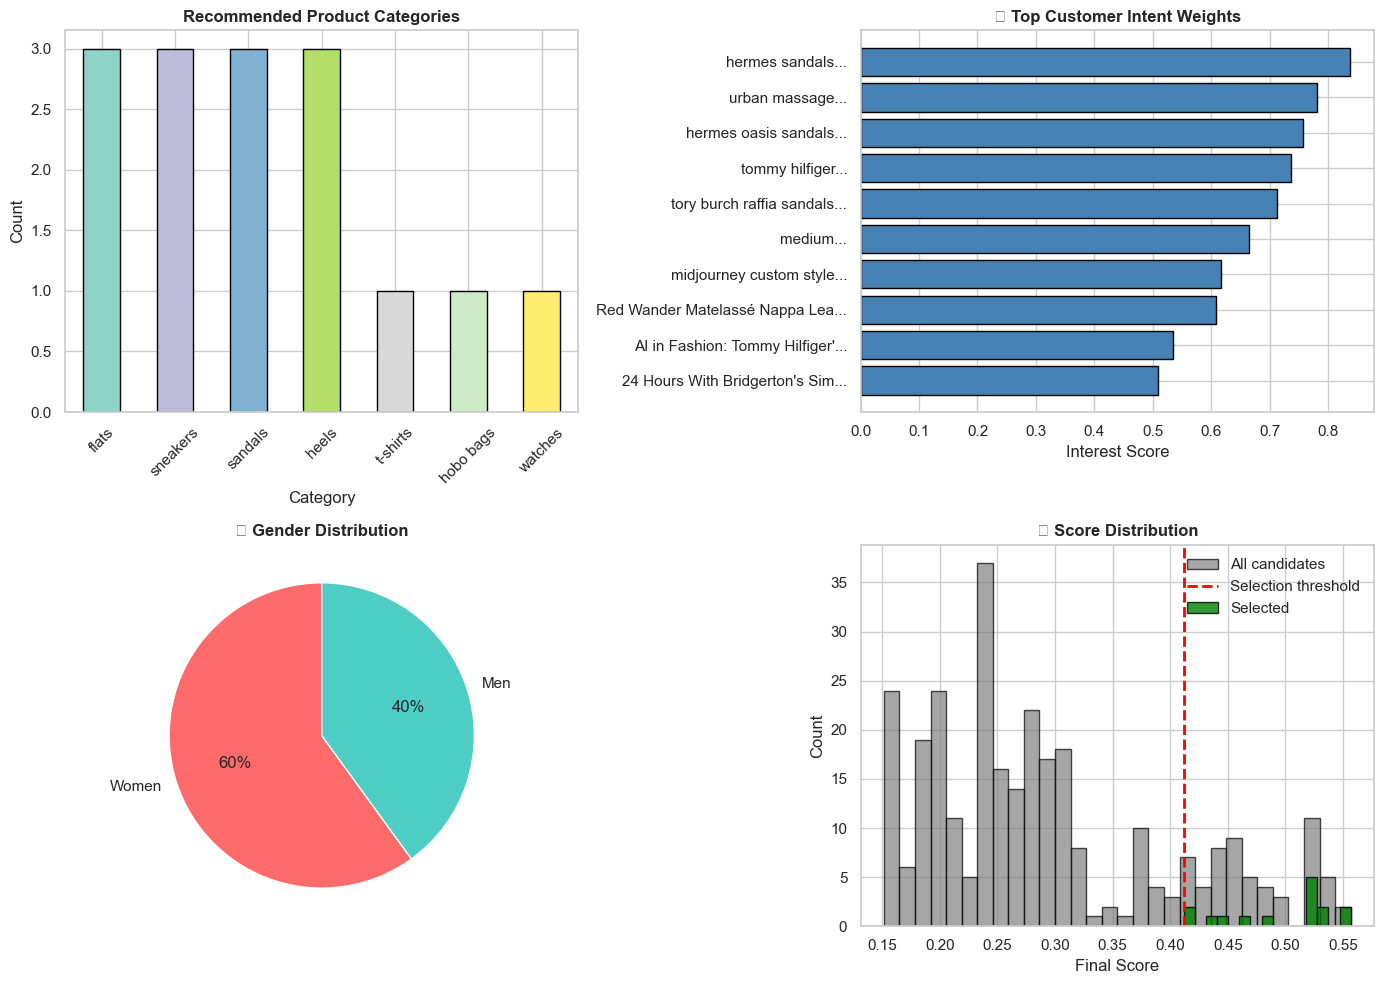

In [114]:
# Visualization 1: Visualizing Recommendation Analysis to
# understand category distribution, intent weights, gender distribution, and score distribution.


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Category Distribution in Recommendations
ax1 = axes[0, 0]
cat_counts = final_recommendations['CATEGORY'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(cat_counts)))
cat_counts.plot(kind='bar', ax=ax1, color=colors, edgecolor='black')
ax1.set_title('Recommended Product Categories', fontsize=12, fontweight='bold')
ax1.set_xlabel('Category')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Intent Query Weights
ax2 = axes[0, 1]
intent_data = pd.DataFrame({'query': intent_queries, 'weight': intent_weights})
intent_data = intent_data.nlargest(10, 'weight')
intent_data['query_short'] = intent_data['query'].str[:30] + '...'
ax2.barh(intent_data['query_short'], intent_data['weight'], color='steelblue', edgecolor='black')
ax2.set_title('🎯 Top Customer Intent Weights', fontsize=12, fontweight='bold')
ax2.set_xlabel('Interest Score')
ax2.invert_yaxis()

# 3. Gender Distribution
ax3 = axes[1, 0]
gender_map = {'F': 'Women', 'M': 'Men', 'U': 'Unisex'}
gender_counts = final_recommendations['GENDER'].map(gender_map).value_counts()
colors_gender = ['#ff6b6b', '#4ecdc4', '#95a5a6']
ax3.pie(gender_counts, labels=gender_counts.index, autopct='%1.0f%%', 
        colors=colors_gender[:len(gender_counts)], startangle=90)
ax3.set_title('👗 Gender Distribution', fontsize=12, fontweight='bold')

# 4. Score Distribution
ax4 = axes[1, 1]
ax4.hist(candidates_df['final_score'], bins=30, alpha=0.7, color='gray', label='All candidates', edgecolor='black')
ax4.axvline(final_recommendations['final_score'].min(), color='red', linestyle='--', 
            label=f'Selection threshold', linewidth=2)
ax4.hist(final_recommendations['final_score'], bins=15, alpha=0.8, color='green', label='Selected', edgecolor='black')
ax4.set_title('📈 Score Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Final Score')
ax4.set_ylabel('Count')
ax4.legend()

plt.tight_layout()
plt.savefig('recommendation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

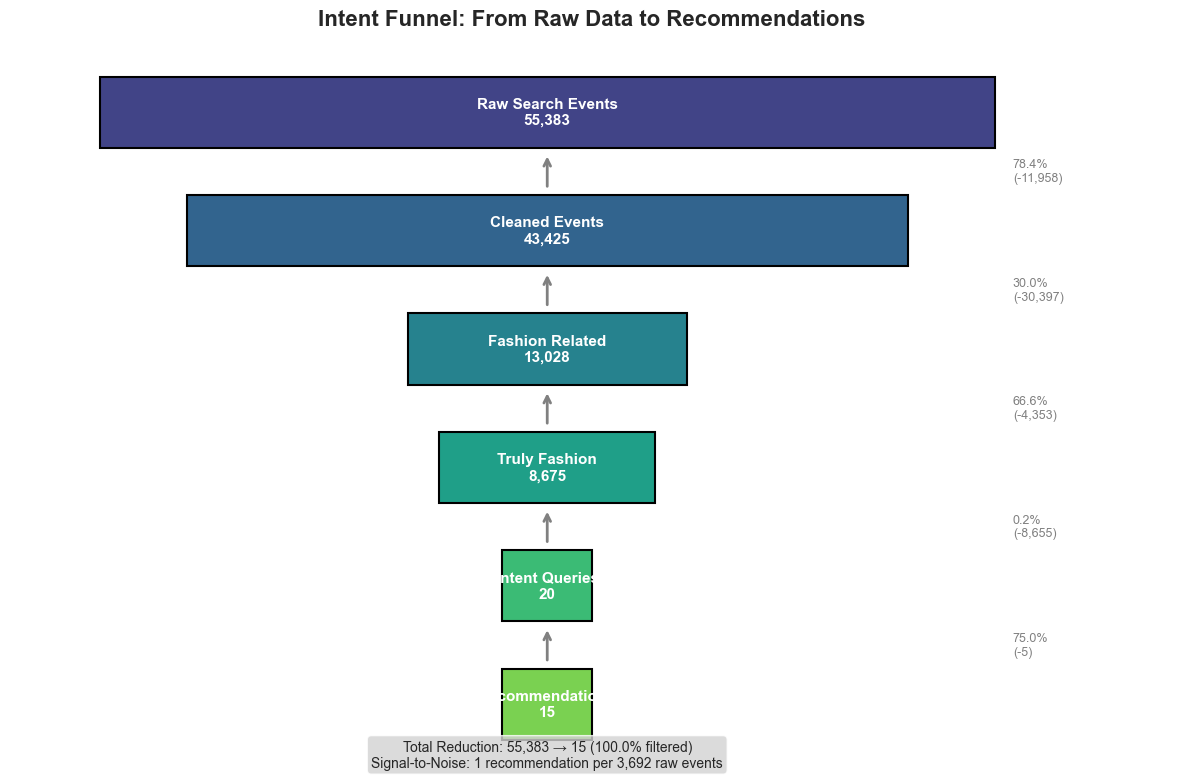


FUNNEL ANALYSIS SUMMARY

  Raw Search Events: 55,383
  ↓ Cleaned Events: 43,425 (78.4% retention, -11,958 dropped)
  ↓ Fashion Related: 13,028 (30.0% retention, -30,397 dropped)
  ↓ Truly Fashion: 8,675 (66.6% retention, -4,353 dropped)
  ↓ Intent Queries: 20 (0.2% retention, -8,655 dropped)
  ↓ Recommendations: 15 (75.0% retention, -5 dropped)
Total Reduction: 55,383 → 15 (99.97% filtered)
Signal-to-Noise Ratio: 1 recommendation per 3,692 raw events


In [ ]:
# Visualization 2: Intent Funnel Visualization (Sankey Style) to illustrate data reduction
# from raw search events to final recommendations.

# Define the funnel stages with actual counts from our pipeline
funnel_data = {
    'Raw Search Events': len(search_df),
    'Cleaned Events': len(cleaned_df),
    'Fashion Related': len(fashion_df),
    'Truly Fashion': len(truly_fashion_df),
    'Intent Queries': len(intent_queries),
    'Recommendations': len(final_recommendations)
}

labels = list(funnel_data.keys())
values = list(funnel_data.values())

# Create a funnel chart using matplotlib (horizontal bar chart style)
fig, ax = plt.subplots(figsize=(12, 8))

# Normalize values for visualization (log scale for better visibility)
max_val = values[0]
normalized = [v / max_val for v in values]

# Colors gradient from blue to green
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(labels)))

# Create horizontal funnel bars (centered)
y_positions = np.arange(len(labels))[::-1]  # Reverse for top-to-bottom flow
bar_heights = 0.6

for i, (label, val, norm, color) in enumerate(zip(labels, values, normalized, colors)):
    # Draw centered bar
    bar_width = norm * 0.9 + 0.1  # Minimum width of 0.1
    left_pos = (1 - bar_width) / 2
    
    ax.barh(y_positions[i], bar_width, height=bar_heights, left=left_pos, 
            color=color, edgecolor='black', linewidth=1.5)
    
    # Add label and count
    ax.text(0.5, y_positions[i], f"{label}\n{val:,}", 
            ha='center', va='center', fontsize=11, fontweight='bold', color='white')

# Add flow arrows and retention percentages
for i in range(len(values) - 1):
    retention = (values[i+1] / values[i]) * 100
    drop = values[i] - values[i+1]
    
    # Arrow between bars
    ax.annotate('', xy=(0.5, y_positions[i] - 0.35), xytext=(0.5, y_positions[i+1] + 0.35),
                arrowprops=dict(arrowstyle='->', color='gray', lw=2))
    
    # Retention text on the right
    ax.text(1.02, (y_positions[i] + y_positions[i+1]) / 2, 
            f"{retention:.1f}%\n(-{drop:,})", 
            ha='left', va='center', fontsize=9, color='gray')

# Styling
ax.set_xlim(-0.1, 1.2)
ax.set_ylim(-0.5, len(labels) - 0.5)
ax.axis('off')
ax.set_title('Intent Funnel: From Raw Data to Recommendations', 
             fontsize=16, fontweight='bold', pad=20)

# Add summary box
total_reduction = (1 - values[-1] / values[0]) * 100
summary_text = f"Total Reduction: {values[0]:,} → {values[-1]:,} ({total_reduction:.1f}% filtered)\nSignal-to-Noise: 1 recommendation per {values[0]//values[-1]:,} raw events"
ax.text(0.5, -0.3, summary_text, ha='center', va='top', fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('intent_funnel.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Print detailed summary
print("\nFUNNEL ANALYSIS SUMMARY\n")

for i, (stage, count) in enumerate(funnel_data.items()):
    if i == 0:
        print(f"  {stage}: {count:,}")
    else:
        prev_count = list(funnel_data.values())[i-1]
        retention = (count / prev_count) * 100
        drop = prev_count - count
        print(f"  ↓ {stage}: {count:,} ({retention:.1f}% retention, -{drop:,} dropped)")

print(f"Total Reduction: {values[0]:,} → {values[-1]:,} ({total_reduction:.2f}% filtered)")
print(f"Signal-to-Noise Ratio: 1 recommendation per {values[0]//values[-1]:,} raw events")

Total points for UMAP: 265
- Catalog samples: 200
- User searches: 50
- Recommendations: 15


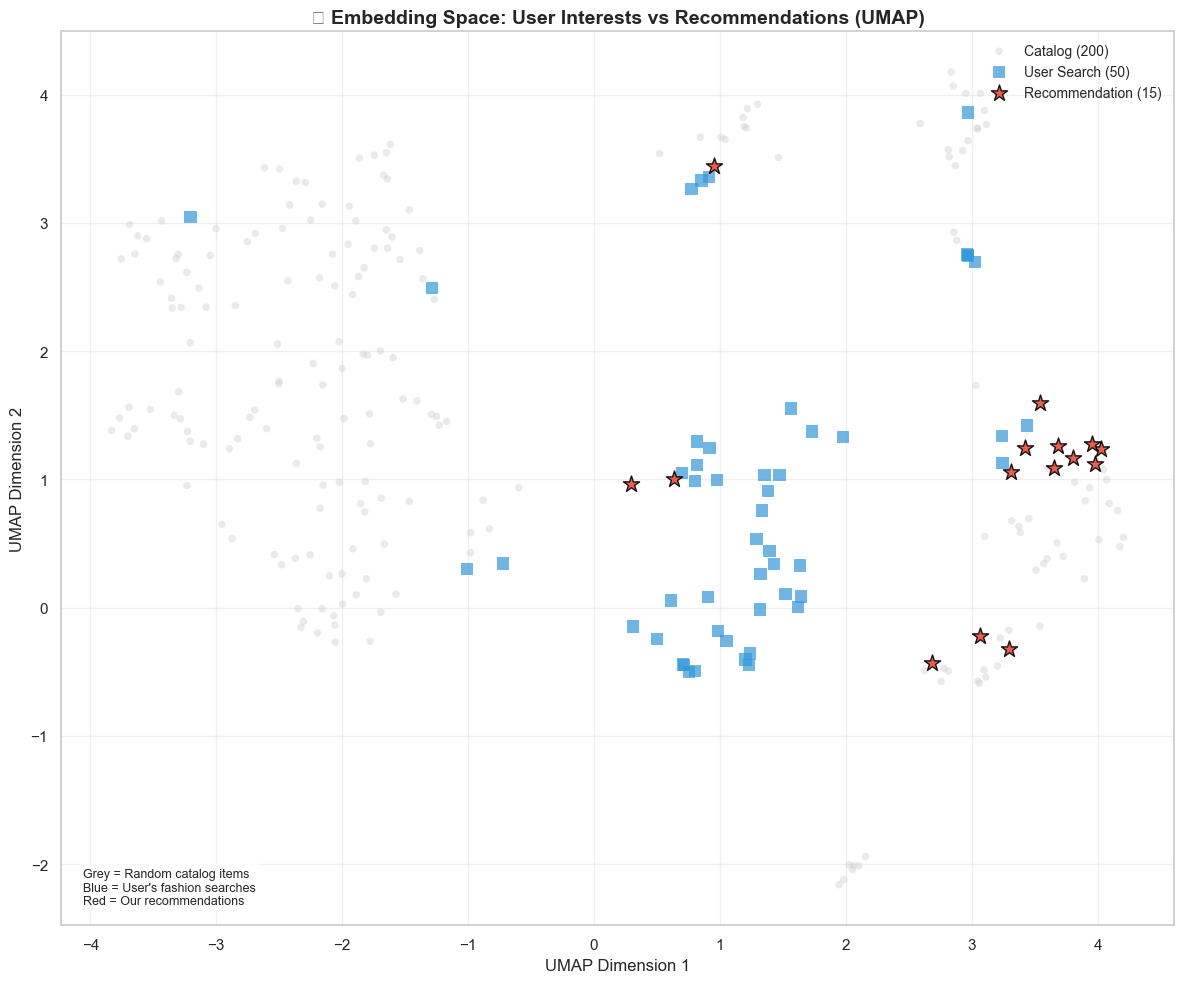


CLUSTERING ANALYSIS

Avg distance: Recommendations → User Searches: 0.53
Avg distance: Recommendations → Random Catalog: 0.31

Recommendations are 0.6x closer to user searches than random catalog items


In [ ]:
# Visualization 3: Embedding Space Visualization (UMAP) to visualize how user interests and recommendations
# are distributed in the embedding space compared to random catalog items.

import umap

# 1. Sample 200 random catalog items (grey background)
np.random.seed(42)
sample_catalog_idx = np.random.choice(len(catalog_df), size=200, replace=False)
sample_catalog_embeddings = product_embeddings_norm[sample_catalog_idx]
sample_catalog_labels = ['Catalog'] * len(sample_catalog_idx)

# 2. Get user's top fashion search embeddings (blue - user interests)
top_fashion_texts = fashion_df.nlargest(50, 'interest_score')['event_text'].tolist()
top_fashion_embeddings = model.encode(top_fashion_texts)
top_fashion_embeddings_norm = normalize(top_fashion_embeddings)
fashion_search_labels = ['User Search'] * len(top_fashion_texts)

# 3. Get final recommendation embeddings (red - our picks)
rec_indices = []
for url in final_recommendations['LYST_PRODUCT_URL']:
    idx = catalog_df[catalog_df['LYST_PRODUCT_URL'] == url].index
    if len(idx) > 0:
        rec_indices.append(idx[0])
rec_embeddings = product_embeddings_norm[rec_indices]
rec_labels = ['Recommendation'] * len(rec_indices)

# Combine all embeddings
all_embeddings = np.vstack([
    sample_catalog_embeddings,
    top_fashion_embeddings_norm,
    rec_embeddings
])
all_labels = sample_catalog_labels + fashion_search_labels + rec_labels

print(f"Total points for UMAP: {len(all_embeddings)}")
print(f"- Catalog samples: {len(sample_catalog_idx)}")
print(f"- User searches: {len(top_fashion_texts)}")
print(f"- Recommendations: {len(rec_indices)}")

# Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='cosine')
embeddings_2d = reducer.fit_transform(all_embeddings)

# Create DataFrame for plotting
umap_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'type': all_labels
})

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Define colors and sizes for each type
type_config = {
    'Catalog': {'color': '#cccccc', 'size': 30, 'alpha': 0.4, 'marker': 'o', 'zorder': 1},
    'User Search': {'color': '#3498db', 'size': 80, 'alpha': 0.7, 'marker': 's', 'zorder': 2},
    'Recommendation': {'color': '#e74c3c', 'size': 150, 'alpha': 0.9, 'marker': '*', 'zorder': 3}
}

# Plot each type
for label, config in type_config.items():
    subset = umap_df[umap_df['type'] == label]
    ax.scatter(subset['x'], subset['y'], 
               c=config['color'], s=config['size'], alpha=config['alpha'],
               marker=config['marker'], label=f"{label} ({len(subset)})",
               edgecolors='black' if label == 'Recommendation' else 'none',
               linewidths=1 if label == 'Recommendation' else 0,
               zorder=config['zorder'])

# Styling
ax.set_title('🎯 Embedding Space: User Interests vs Recommendations (UMAP)', fontsize=14, fontweight='bold')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add annotation
ax.text(0.02, 0.02, 
        "Grey = Random catalog items\nBlue = User's fashion searches\nRed = Our recommendations",
        transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('embedding_umap.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Analysis: Check if recommendations cluster near user searches
print("\nCLUSTERING ANALYSIS\n")

from scipy.spatial.distance import cdist

rec_points = umap_df[umap_df['type'] == 'Recommendation'][['x', 'y']].values
search_points = umap_df[umap_df['type'] == 'User Search'][['x', 'y']].values
catalog_points = umap_df[umap_df['type'] == 'Catalog'][['x', 'y']].values

# Average min distance from recommendations to nearest user search
rec_to_search_dist = cdist(rec_points, search_points).min(axis=1).mean()
rec_to_catalog_dist = cdist(rec_points, catalog_points).min(axis=1).mean()

print(f"Avg distance: Recommendations → User Searches: {rec_to_search_dist:.2f}")
print(f"Avg distance: Recommendations → Random Catalog: {rec_to_catalog_dist:.2f}")
print(f"\nRecommendations are {rec_to_catalog_dist/rec_to_search_dist:.1f}x closer to user searches than random catalog items")

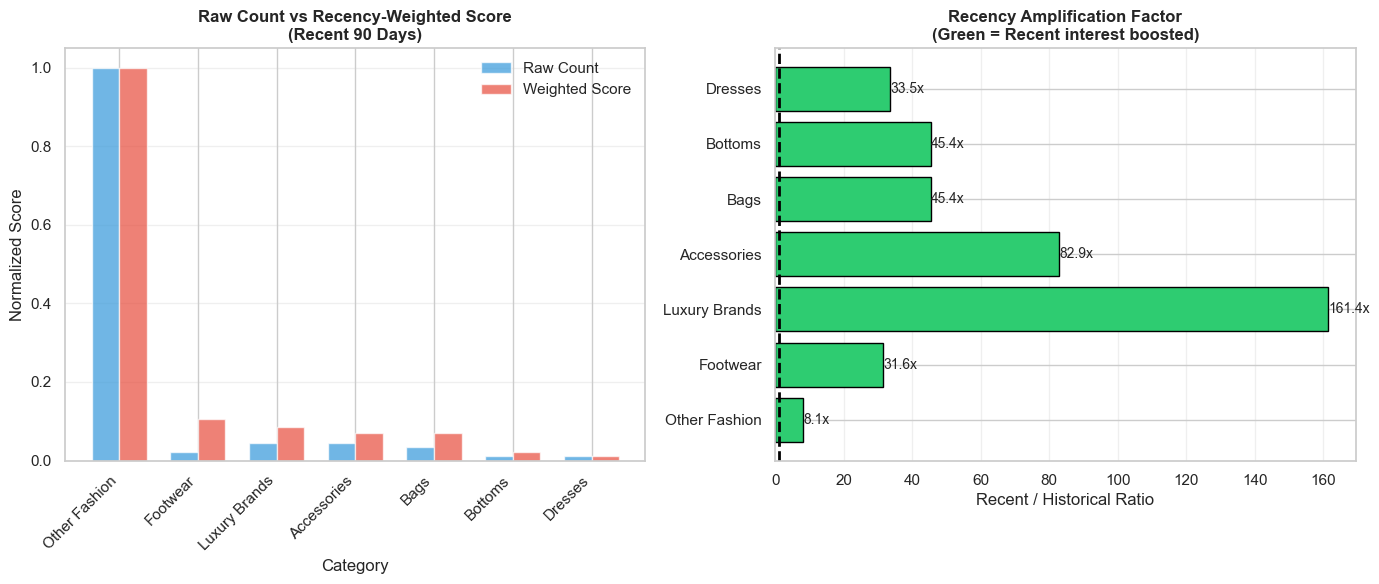


RECENCY WEIGHTING VALIDATION

Recent period: 2024-03-25 to 2024-06-23 (last 90 days)
Historical period: Before 2024-03-25

Top categories by RECENCY-WEIGHTED score:
   Other Fashion: 26.15 (boosted 8.1x vs historical)
   Footwear: 2.79 (boosted 31.6x vs historical)
   Luxury Brands: 2.24 (boosted 161.4x vs historical)
   Accessories: 1.86 (boosted 82.9x vs historical)
   Bags: 1.84 (boosted 45.4x vs historical)


In [ ]:
# Visualization 4: Recent vs Historical Interest Comparison to validate recency weighting impact.

# Assumption: Defining fashion category keywords for classification
category_keywords = {
    'Footwear': ['shoe', 'shoes', 'boot', 'boots', 'sandal', 'sandals', 'sneaker', 'sneakers', 
                 'heel', 'heels', 'loafer', 'flats', 'oxford', 'slipper'],
    'Bags': ['bag', 'bags', 'handbag', 'purse', 'clutch', 'tote', 'backpack', 'hobo'],
    'Tops': ['shirt', 'blouse', 'top', 'sweater', 'cardigan', 'hoodie', 'jacket', 
             't-shirt', 'tee', 'polo', 'blazer', 'coat'],
    'Bottoms': ['pants', 'jeans', 'shorts', 'skirt', 'trousers', 'leggings'],
    'Dresses': ['dress', 'dresses', 'gown', 'jumpsuit', 'romper'],
    'Accessories': ['watch', 'sunglasses', 'belt', 'scarf', 'hat', 'jewelry', 'bracelet'],
    'Luxury Brands': ['hermes', 'gucci', 'prada', 'louis vuitton', 'chanel', 'dior', 
                      'tory burch', 'tommy hilfiger', 'balenciaga']
}

def classify_category(text):
    text_lower = text.lower()
    for category, keywords in category_keywords.items():
        if any(kw in text_lower for kw in keywords):
            return category
    return 'Other Fashion'

# Classify fashion events
fashion_temporal = truly_fashion_df.copy()
fashion_temporal['category'] = fashion_temporal['event_text'].apply(classify_category)

# Split into recent (last 90 days) vs historical
max_date = fashion_temporal['timestamp'].max()
cutoff_date = max_date - pd.Timedelta(days=90)

recent_events = fashion_temporal[fashion_temporal['timestamp'] > cutoff_date]
historical_events = fashion_temporal[fashion_temporal['timestamp'] <= cutoff_date]

# Aggregate by category
recent_by_cat = recent_events.groupby('category').agg({
    'interest_score': 'sum',
    'event_text': 'count'
}).rename(columns={'event_text': 'count', 'interest_score': 'weighted_score'})

historical_by_cat = historical_events.groupby('category').agg({
    'interest_score': 'sum', 
    'event_text': 'count'
}).rename(columns={'event_text': 'count', 'interest_score': 'weighted_score'})

# Combine for comparison
comparison_df = pd.DataFrame({
    'Recent (90d) Count': recent_by_cat['count'],
    'Recent (90d) Weighted': recent_by_cat['weighted_score'],
    'Historical Count': historical_by_cat['count'],
    'Historical Weighted': historical_by_cat['weighted_score']
}).fillna(0)

# Calculate recency boost factor
comparison_df['Count Ratio (Recent/Hist)'] = (comparison_df['Recent (90d) Count'] + 1) / (comparison_df['Historical Count'] + 1)
comparison_df['Weight Ratio (Recent/Hist)'] = (comparison_df['Recent (90d) Weighted'] + 0.01) / (comparison_df['Historical Weighted'] + 0.01)

# Sort by recent weighted score
comparison_df = comparison_df.sort_values('Recent (90d) Weighted', ascending=False)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Side-by-side comparison of raw counts vs weighted scores
ax1 = axes[0]
categories = comparison_df.head(7).index.tolist()
x = np.arange(len(categories))
width = 0.35

# Normalize for comparison
recent_counts_norm = comparison_df.loc[categories, 'Recent (90d) Count'] / comparison_df.loc[categories, 'Recent (90d) Count'].max()
recent_weighted_norm = comparison_df.loc[categories, 'Recent (90d) Weighted'] / comparison_df.loc[categories, 'Recent (90d) Weighted'].max()

bars1 = ax1.bar(x - width/2, recent_counts_norm, width, label='Raw Count', color='#3498db', alpha=0.7)
bars2 = ax1.bar(x + width/2, recent_weighted_norm, width, label='Weighted Score', color='#e74c3c', alpha=0.7)

ax1.set_xlabel('Category')
ax1.set_ylabel('Normalized Score')
ax1.set_title('Raw Count vs Recency-Weighted Score\n(Recent 90 Days)', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Recency boost factor - how much recent activity is amplified
ax2 = axes[1]
boost_data = comparison_df[comparison_df['Recent (90d) Weighted'] > 0.1].head(7)
colors = ['#2ecc71' if x > 1 else '#e74c3c' for x in boost_data['Weight Ratio (Recent/Hist)']]

bars = ax2.barh(boost_data.index, boost_data['Weight Ratio (Recent/Hist)'], color=colors, edgecolor='black')
ax2.axvline(x=1, color='black', linestyle='--', linewidth=2, label='Equal weight')
ax2.set_xlabel('Recent / Historical Ratio')
ax2.set_title('Recency Amplification Factor\n(Green = Recent interest boosted)', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar, val in zip(bars, boost_data['Weight Ratio (Recent/Hist)']):
    ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}x', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('recency_validation.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Summary
print("\nRECENCY WEIGHTING VALIDATION\n")
print(f"Recent period: {cutoff_date.date()} to {max_date.date()} (last 90 days)")
print(f"Historical period: Before {cutoff_date.date()}")
print(f"\nTop categories by RECENCY-WEIGHTED score:")
for cat in comparison_df.head(5).index:
    row = comparison_df.loc[cat]
    print(f"   {cat}: {row['Recent (90d) Weighted']:.2f} (boosted {row['Weight Ratio (Recent/Hist)']:.1f}x vs historical)")
